In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from hlpr_func import make_cyclic, lat_mean, calc_trend_HAC, get_weights_values, linreg_weighted

nicename = {"F_TOA": "$F^\\uparrow_{TOA}$",
             "F_surf": "$F_{surf}$",
             "F_clr": "$F_{clr}$",
             "F_cloud": "$F_{cloud}$",
             "aod": "AOD",
             "ssaod550": "Sea salt AOD",
             "si10": "Wind speed"}

plotcolor = {"F_TOA": "black",
             "F_surf": "mediumseagreen",
             "F_clr": "hotpink",
             "F_cloud": "deepskyblue",
             "aod": "brown",
             "ssaod550": "darkblue",
             "si10": "black"}

units = {"F_TOA":"W m$^{-2}$",
         "F_surf":"W m$^{-2}$",
         "F_clr":"W m$^{-2}$",
         "F_cloud":"W m$^{-2}$",
         "aod":"-",
         "ssaod550":"-",
         "si10":"m s$^{-1}$"}

In [2]:
# open all the data and merge together
ceres = make_cyclic(xr.open_mfdataset("CERES-data/CERES_Cru23_ds.nc"))

aqua = xr.open_dataset("MODIS_AOD/Aqua_combined.nc").sortby("lat")
aqua["lon"] = (aqua.coords['lon'] + 360) % 360
aqua = make_cyclic(aqua.sortby("lon").sel(time=slice("2000-03","2023-12")))
aqua = aqua.rename_vars({"aod":"aod_aqua"}).drop_vars("sza")
ds = xr.merge([ceres, aqua])
ceres.close()
aqua.close()

terra = xr.open_dataset("MODIS_AOD/Terra_combined.nc").sortby("lat")
terra["lon"] = (terra.coords['lon'] + 360) % 360
terra = make_cyclic(terra.sortby("lon").sel(time=slice("2000-03","2023-12")))
terra = terra.rename_vars({"aod":"aod_terra"}).drop_vars("sza")
ds = xr.merge([ds, terra])
terra.close()

era = xr.open_dataset("ERA5-CAMS/era5-interpolated.nc")
ds = xr.merge([ds, era])
era.close()

aod_modis = np.nanmean(np.stack([ds.aod_aqua.values, ds.aod_terra.values]), axis=0)
aod_modis = xr.DataArray(aod_modis, coords=ds.aod_aqua.coords, dims=ds.aod_aqua.dims)
ds["aod"] = aod_modis

ds = ds[["F_clr","aod","si10","ssaod550","landmask"]]
ds

/glade/derecho/scratch/csinger/tmp/ipykernel_219148/817184021.py:23: RuntimeWarning: Mean of empty slice
  aod_modis = np.nanmean(np.stack([ds.aod_aqua.values, ds.aod_terra.values]), axis=0)


<xarray.Dataset> Size: 601MB
Dimensions:   (time: 289, lat: 180, lon: 361)
Coordinates:
  * lon       (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 357.5 358.5 359.5 360.5
  * lat       (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time      (time) datetime64[ns] 2kB 2000-03-15 2000-04-15 ... 2024-03-15
Data variables:
    F_clr     (time, lat, lon) float32 75MB 34.51 34.51 34.51 ... 16.89 16.89
    aod       (lat, lon, time) float32 75MB nan nan nan nan ... nan nan nan nan
    si10      (time, lat, lon) float64 150MB 4.97 4.975 4.98 ... 6.332 6.332 nan
    ssaod550  (time, lat, lon) float64 150MB nan nan nan nan ... nan nan nan nan
    landmask  (time, lat, lon) float64 150MB 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 nan
Attributes:
    title:        CERES EBAF TOA and Surface Fluxes. Monthly Averages and 07/...
    institution:  NASA Langley Research Center
    Conventions:  CF-1.4
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.2; Revised data Release Date January 2, 2024
    DOI:          10.5067/TERRA-AQUA-NOAA20/CERES/EBAF_L3B004.2

In [3]:
# add extra coord
da = ds.assign_coords({"month_since_start": ("time", np.arange(len(ds.time.values)))})

# select only DJF
djf = da.where(ds.time.dt.month.isin([12,1,2]))

# remove austrailian bush fires (Dec 2019 - Mar 2020)
djf = djf.where(~(djf.time.dt.year.isin(2019) & djf.time.dt.month.isin(12)))
djf = djf.where(~(djf.time.dt.year.isin(2020) & djf.time.dt.month.isin([1,2])))

# add weights
weights = djf.time.dt.days_in_month
weights = weights.where(weights.time.dt.month!=2, 28.65)
djf["days_in_month"] = weights

# calculate climatology and remove seasons
climatology = djf.groupby("time.month").mean("time")
deseasonalized = djf.groupby("time.month") - climatology + climatology.weighted(climatology.days_in_month).mean("month")

# take regional mean over Southern Ocean
so = lat_mean(deseasonalized.sel(lat=slice(-75,-45)).where(deseasonalized.landmask==0).mean("lon"))
so["days_in_month"] = weights

# swap time to monotonic index
da = so.swap_dims({"time":"month_since_start"})

# calculate linear trend
polyfit_result = da.polyfit("month_since_start", 1, skipna=True, w=da.days_in_month)
so_linear = da.month_since_start * polyfit_result.sel(degree=1) + polyfit_result.sel(degree=0)
for v in so_linear.keys():
    so_linear = so_linear.rename_vars({v:v.split("_polyfit")[0]})
so_linear = so_linear.swap_dims({"month_since_start":"time"})

# remove linear trend
so_detrended = so - so_linear

# save trend separately
trend = polyfit_result.sel(degree=1) * 120 # per decade
for v in trend.keys():
    trend = trend.rename_vars({v:v.split("_polyfit")[0]})

a1 = slope(F_clr vs. aod) = 39.3346
actual aod trend = 0.0109
actual F_clr trend = 0.4980
predicted F_clr trend = 0.4304

a1 = slope(aod vs. si10) = 0.0184
actual si10 trend = 0.2204
actual aod trend = 0.0109
predicted aod trend = 0.0041

DJF (w/o '19-'20), Southern Ocean (45-75°S, ocean only), Detrended & deseasonalized anomalies


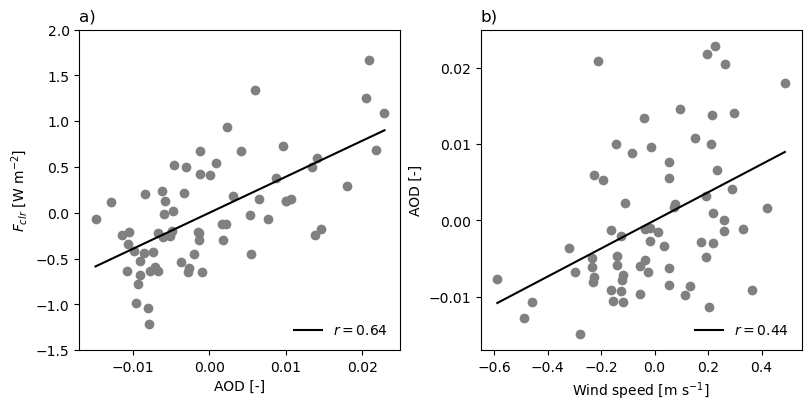

In [4]:
fig, axes = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)

yvar = ["F_clr", "aod"]
ylim = [[-1.5,2], [-0.017,0.025]]
yticks = [np.linspace(-1.5, 2, 8), np.linspace(-0.01, 0.02, 4)]
xvar = ["aod", "si10"]
xlim = [[-0.017,0.025], [-0.65,0.55]]
xticks = [np.linspace(-0.01, 0.02, 4), np.linspace(-0.6, 0.4, 6)]

for i,var in enumerate(xvar):
    ax = axes.flatten()[i]

    if var == "skip":
        ax.remove()
        continue

    ax.plot(so_detrended[xvar[i]], so_detrended[yvar[i]], marker="o", lw=0, color="grey")
    ax.set_xlabel(nicename[xvar[i]]+" ["+units[xvar[i]]+"]")
    ax.set_ylabel(nicename[yvar[i]]+" ["+units[yvar[i]]+"]")
    ax.set_xlim(xlim[i])
    ax.set_xticks(xticks[i])
    ax.set_ylim(ylim[i])
    ax.set_yticks(yticks[i])

    xval, yval = so_detrended[xvar[i]].values, so_detrended[yvar[i]].values
    ww = (~np.isnan(xval) & ~np.isnan(yval))
    idx = np.argsort(xval[ww])
    xsort, ysort = xval[ww][idx], yval[ww][idx]
    weights = get_weights_values(so_detrended[xvar])[ww][idx]
    result = linreg_weighted(xsort, ysort, weights)
    ax.plot(xsort, xsort*result["slope"], color="k", 
            label="$r = ${:.2f}".format(result["rvalue"]))
    ax.legend(loc=4, frameon=False)
    ax.set_title("a)" if i == 0 else "b)", loc="left")

    a1 = result["slope"]
    print(f"a1 = slope({yvar[i]} vs. {xvar[i]}) = {a1:.4f}")
    print(f"actual {xvar[i]} trend = {trend[xvar[i]].values:.4f}")
    print(f"actual {yvar[i]} trend = {trend[yvar[i]].values:.4f}")
    print(f"predicted {yvar[i]} trend = {a1 * trend[xvar[i]].values:.4f}")
    print()

print("DJF (w/o '19-'20), Southern Ocean (45-75°S, ocean only), Detrended & deseasonalized anomalies")
plt.savefig("talk-figures/scatter_detrended.png",dpi=200,facecolor="w",bbox_inches="tight")
plt.savefig("paper-figures/scatter_detrended.png",dpi=200,facecolor="w",bbox_inches="tight")
plt.show()

In [5]:
# calculate linear trend on whole SO region
da = deseasonalized.sel(time=slice("2003","2023"))
da = da.assign_coords({"month_since_2003-01": ("time", np.arange(len(da.time.values)))})
da = da.swap_dims({"time":"month_since_2003-01"})
fit = da.polyfit("month_since_2003-01",1,w=da.days_in_month)
da.close()

fit

/glade/u/home/csinger/anaconda3/envs/albedo/lib/python3.12/site-packages/xarray/core/nputils.py:256: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


<xarray.Dataset> Size: 5MB
Dimensions:                             (degree: 2, lat: 180, lon: 361)
Coordinates:
  * degree                              (degree) int64 16B 1 0
  * lon                                 (lon) float32 1kB 0.5 1.5 ... 360.5
  * lat                                 (lat) float32 720B -89.5 -88.5 ... 89.5
Data variables:
    F_clr_polyfit_coefficients          (degree, lat, lon) float64 1MB -0.004...
    aod_polyfit_coefficients            (degree, lat, lon) float64 1MB nan .....
    si10_polyfit_coefficients           (degree, lat, lon) float64 1MB 2.454e...
    ssaod550_polyfit_coefficients       (degree, lat, lon) float64 1MB 1.037e...
    landmask_polyfit_coefficients       (degree, lat, lon) float64 1MB 8.589e...
    days_in_month_polyfit_coefficients  (degree) float64 16B -1.295e-17 30.49

DJF (w/o '19-'20), Southern Ocean (45-75°S, Ocean only)


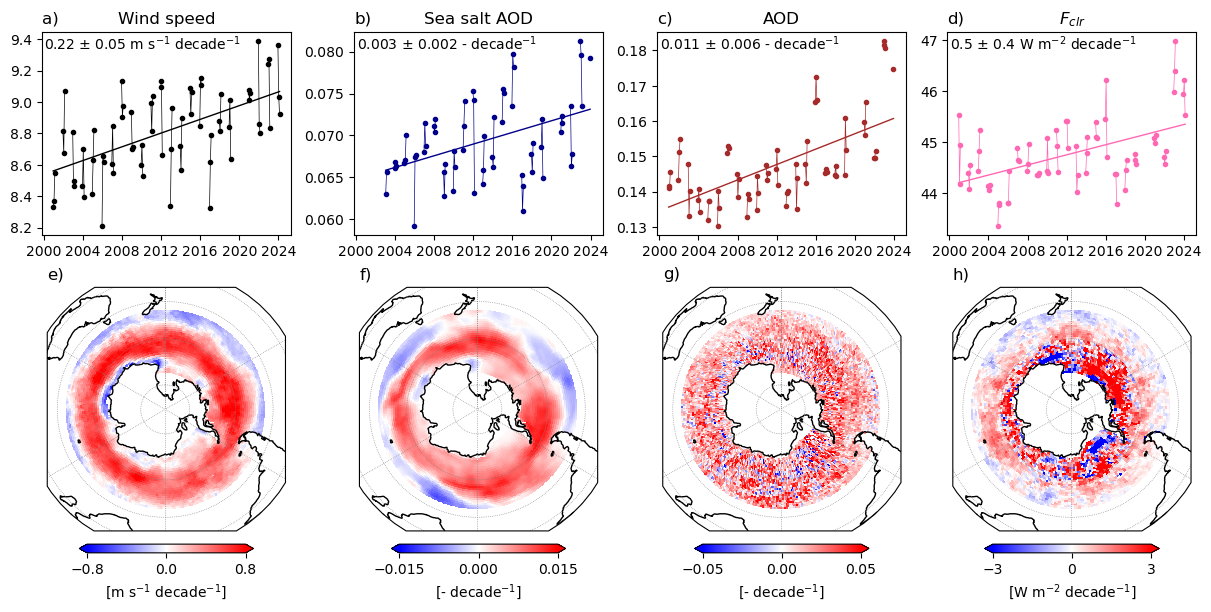

In [6]:
print("DJF (w/o '19-'20), Southern Ocean (45-75°S, Ocean only)")

fig = plt.figure(figsize=(12,6), constrained_layout=True)
gs = fig.add_gridspec(ncols=4, nrows=2, height_ratios=[1, 1.2])
crange = {"F_clr":3, "aod":0.05, "ssaod550":0.015, "si10":0.8}

letter = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)"]
for i,var in enumerate(["si10", "ssaod550", "aod", "F_clr"]):
    ax = fig.add_subplot(gs[0,i])
    if i == 0:
        ax1 = ax
    else:
        ax.sharex(ax1)

    y = so[var].dropna(dim="time")
    t = y.month_since_start.values
    w = get_weights_values(y)
    fitted, trend, trend_pm = calc_trend_HAC(t, y.values, w, hac_maxlags=12)

    ax.plot(y.time, fitted, color=plotcolor[var], lw=1)
    ax.plot(so.time, so[var], ".-", color=plotcolor[var], lw=0.5)
    
    if var == "si10":
        ax.text(0.01, 0.99, f"{trend*120:.2f} $\\pm$ {trend_pm*120:.2f}"+" "+units[var]+" decade$^{-1}$", ha='left', va='top', transform=ax.transAxes, fontsize=10)
    elif var == "F_clr":
        ax.text(0.01, 0.99, f"{trend*120:.1f} $\\pm$ {trend_pm*120:.1f}"+" "+units[var]+" decade$^{-1}$", ha='left', va='top', transform=ax.transAxes, fontsize=10)
    else:
        ax.text(0.01, 0.99, f"{trend*120:.3f} $\\pm$ {trend_pm*120:.3f}"+" "+units[var]+" decade$^{-1}$", ha='left', va='top', transform=ax.transAxes, fontsize=10)
    ax.set_title(nicename[var])
    ax.set_title(letter[i], loc="left")

    ####
    ax = fig.add_subplot(gs[1,i], projection=ccrs.Orthographic(180, -90))
    ax.set_extent([-180, 180, -90, -30], crs=ccrs.PlateCarree())
    ax.set_aspect('equal', 'box')
    
    trend = fit.sel(degree=1)[var+"_polyfit_coefficients"] * 120 # convert from per month to per decade
    trend = trend.where(ds.landmask.mean("time") == 0).where((ds.lat < -45) & (ds.lat > -75))

    cf = ax.pcolormesh(ds.lon, ds.lat, trend, vmin=-crange[var], vmax=crange[var],
                cmap="bwr", transform=ccrs.PlateCarree())

    ax.coastlines()
    ax.set_title(letter[i+4], loc="left")
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='gray', linestyle=':')
    plt.colorbar(cf, extend="both", label="["+units[var]+" decade$^{-1}$]",
                 orientation='horizontal', shrink=0.7, ticks = np.linspace(-crange[var],crange[var],3))

plt.savefig("talk-figures/djf_ws_aod_clr_trends_maps.png", dpi=200, facecolor="w", bbox_inches="tight")
plt.savefig("paper-figures/djf_ws_aod_clr_trends_maps.png", dpi=200, facecolor="w", bbox_inches="tight")
plt.show()

In [7]:
d1 = fit.sel(degree=1)["si10_polyfit_coefficients"] * 120 # convert from per month to per decade
d1 = d1.where(ds.landmask.mean("time") == 0).where((ds.lat < -45) & (ds.lat > -75))

d2 = fit.sel(degree=1)["ssaod550_polyfit_coefficients"] * 120 # convert from per month to per decade
d2 = d2.where(ds.landmask.mean("time") == 0).where((ds.lat < -45) & (ds.lat > -75))

coslatweight = np.cos(np.deg2rad(d1.lat))

corr = xr.corr(d1, d2, dim=["lat","lon"], weights=coslatweight)
print("weighted: ", corr.values)
corr = xr.corr(d1, d2, dim=["lat","lon"])
print("unweighted: ", corr.values)

weighted:  0.7272807743668739
unweighted:  0.7185301652001859


In [8]:
d1 = fit.sel(degree=1)["aod_polyfit_coefficients"] * 120 # convert from per month to per decade
d1 = d1.where(ds.landmask.mean("time") == 0).where((ds.lat < -45) & (ds.lat > -75))

d2 = fit.sel(degree=1)["F_clr_polyfit_coefficients"] * 120 # convert from per month to per decade
d2 = d2.where(ds.landmask.mean("time") == 0).where((ds.lat < -45) & (ds.lat > -75))

coslatweight = np.cos(np.deg2rad(d1.lat))

corr = xr.corr(d1, d2, dim=["lat","lon"], weights=coslatweight)
print("weighted: ", corr.values)
corr = xr.corr(d1, d2, dim=["lat","lon"])
print("unweighted: ", corr.values)

weighted:  0.04408086494582503
unweighted:  0.0339296176522171
